In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import splitfolders
import cv2
from PIL import Image

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

# Data Spliting

In [3]:
input_folder = '/thea/sources/Data/data_train/'
output_folder = '/thea/sources/Data/data/'
splitfolders.ratio(input_folder, output_folder, seed = 24, ratio=(.8, .2), group_prefix=None)

Copying files: 2000 files [00:07, 282.49 files/s]


# Sorting Data

In [4]:
train_img_dir = '/thea/sources/Data/Data/train/images/'
mask_img_dir = '/thea/sources/Data/Data/train/masks/'

img_list = os.listdir(train_img_dir)
img_list.sort()
mask_list = os.listdir(mask_img_dir )
mask_list.sort()

num_images= len(os.listdir(train_img_dir))

print("total number of training images are: ", num_images)



total number of training images are:  962


# Random Checking if Data is aligend 

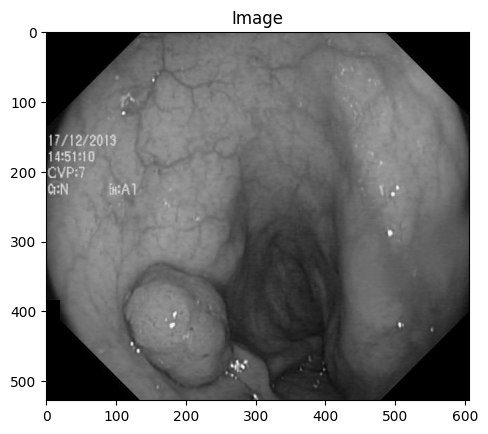

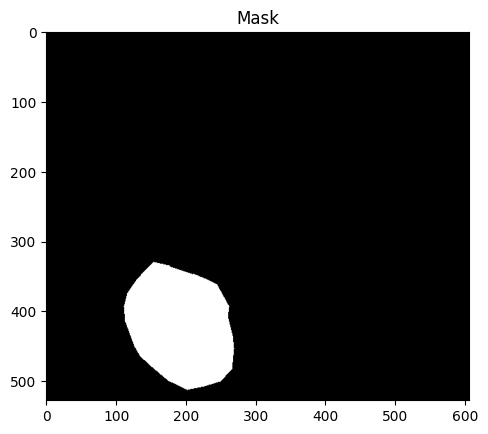

In [9]:
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 0)
mask_for_plot = cv2.imread(mask_img_dir+mask_list[img_num], 0)

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(img_for_plot, cmap = 'gray')
plt.title('Image')

plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(mask_for_plot, cmap = 'gray')
plt.title('Mask')

plt.show()

In [10]:
print('unique before encoding values in mask: ', np.unique(mask_for_plot))

unique before encoding values in mask:  [  0   1   2   3   4   5   6 249 250 251 252 253 254 255]


In [11]:
labelencoder = LabelEncoder()
h, w = mask_for_plot.shape
mask_for_plot_reshaped = mask_for_plot.reshape(-1,1)
mask_for_plot_reshaped_encoded = labelencoder.fit_transform(mask_for_plot_reshaped)
mask_for_plot_encoded = mask_for_plot_reshaped_encoded.reshape(h,w)
print('after encoding: ', np.unique(mask_for_plot_encoded))

after encoding:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


c:\Users\T470S\anaconda3\envs\thea\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
seed = 24
batch_size = 16
n_classes = 4

#Addtional fucntion to preprocess after data generation
def preprocess_data(img, mask, num_class):
    img = img / 255. #scaling image
    labelencoder = LabelEncoder()
    n, h, w, c = mask.shape  
    mask = mask.reshape(-1,1)
    mask = labelencoder.fit_transform(mask)
    mask = mask.reshape(n, h, w, c)
    
    mask = to_categorical(mask, num_class)
      
    return (img, mask)


#data generator defined
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory( train_mask_path, class_mode = None,
     color_mode = 'grayscale', target_size=(256,256), batch_size = batch_size)

    mask_generator = mask_datagen.flow_from_directory( train_mask_path, class_mode = None, 
    color_mode = 'grayscale', target_size=(256,256), batch_size = batch_size)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield(img, mask)


train_img_path = '/thea/sources/Data/Data/train/'
train_mask_path = '/thea/sources/Data/Data/train/'

train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=4)

val_img_path = '/thea/sources/Data/Data/val/'
val_mask_path = '/thea/sources/Data/Data/val/'

val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=4)   

In [31]:
x, y = train_img_gen.__next__()

Found 1924 images belonging to 2 classes.
Found 1924 images belonging to 2 classes.


IndexError: index 24 is out of bounds for axis 1 with size 4

In [32]:
import os

# Check if the directories exist
print(os.path.exists(train_img_path))
print(os.path.exists(train_mask_path))
print(os.path.exists(val_img_path))
print(os.path.exists(val_mask_path))

# List the contents of the directories
print(os.listdir(train_img_path))
print(os.listdir(train_mask_path))
print(os.listdir(val_img_path))
print(os.listdir(val_mask_path))


True
True
True
True
['images', 'masks']
['images', 'masks']
['images', 'masks']
['images', 'masks']


In [29]:
seed = 24
batch_size = 16
n_classes = 4

labelencoder = LabelEncoder()
h, w = mask_for_plot.shape
mask_for_plot_reshaped = mask_for_plot.reshape(-1,1)
mask_for_plot_reshaped_encoded = labelencoder.fit_transform(mask_for_plot_reshaped)
mask_for_plot_encoded = mask_for_plot_reshaped_encoded.reshape(h,w)
print('after encoding: ', np.unique(mask_for_plot_encoded))

seed = 24
batch_size = 16
n_classes = 2
target_size = (256, 256)

#Addtional function to preprocess after data generation
def preprocess_data(img, mask, num_class):
    img = img / 255. #scaling image
    labelencoder = LabelEncoder()
    n, h, w, c = mask.shape  
    mask = mask.reshape(n, h*w*c)  # Flatten y to (n, h*w*c)
    
    mask = labelencoder.fit_transform(mask)  # Encode y
    mask = mask.reshape(n, h, w, c)  # reshape back to original shape

    mask = to_categorical(mask, num_class)  # One-hot encode y
      
    return (img, mask)

#data generator defined
def trainGenerator(train_img_path, train_mask_path, num_class, batch_size, target_size):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path, 
        class_mode=None, 
        color_mode='grayscale', 
        target_sizes =target_size, 
        batch_sizes =batch_size, 
        
    )
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path, 
        class_mode=None, 
        color_mode='grayscale', 
        target_size=target_size, 
        batch_size=batch_size, 
        
    )
    
    train_generator = zip(image_generator, mask_generator)
    
    while True:
        img, mask = (next(image_generator), next(mask_generator))
        img, mask = preprocess_data(img, mask, num_class)
        yield(img, mask)
train_img_path = '/thea/sources/Data/Data/train/'
train_mask_path = '/thea/sources/Data/Data/train/'

train_img_gen = trainGenerator(train_img_path, train_mask_path,num_class=4 )

val_img_path = '/thea/sources/Data/Data/val/'
val_mask_path = '/thea/sources/Data/Data/val/'

val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=4)




after encoding:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


TypeError: trainGenerator() missing 2 required positional arguments: 'batch_size' and 'target_size'

In [27]:
x, y = train_img_gen.__next__()


TypeError: flow_from_directory() got an unexpected keyword argument 'target_sizes'

In [33]:
print(train_img_gen)
print(val_img_gen)

<generator object trainGenerator at 0x0000017502146448>
<generator object trainGenerator at 0x00000175024CCEC8>


In [34]:
img, mask = preprocess_data(img, mask, num_class)
print(img.shape)
print(mask.shape)


NameError: name 'img' is not defined

In [35]:
print(x.shape)
print(y.shape)
print('max value: ', x.max)

NameError: name 'x' is not defined

In [121]:

x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i,:,:,0]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

StopIteration: 

In [122]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Reading Images 

In [129]:
TRAIN_PATH = '/thea/sources/Data/Data/train/images'
TEST_PATH = '/thea/sources/Data/Data/val/images'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype= bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + id_ )[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype= bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.jpg')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')





Resizing training images and masks


0it [00:00, ?it/s]


Resizing test images


0it [00:00, ?it/s]

Done!


In [131]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

# BUILDING MODEL 

In [132]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

# Model Checkpoints 

In [133]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('/thea/sources/models/checkpoints/checkpoint_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)


idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)



ValueError: Training data contains 0 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.1`. Either provide more data, or a different value for the `validation_split` argument.

In [134]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

NameError: name 'preds_train_t' is not defined

In [135]:
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

NameError: name 'ix' is not defined